# Improved One Image Overview for screw-thread

Algorithm is based on draft. Purpose of this notebook:
- clean the previous notebook (move all to python files)
- select different part of raw frame for blending

In [1]:
import math

from tqdm.auto import tqdm
from steps.image_row_stitcher import ImageRowStitcher
from steps.video_camera_motion import VideoMotion
import cv2
import imageio.v3 as iio
import numpy as np
from config.config import *
import matplotlib.pyplot as plt
from scipy.interpolate import RegularGridInterpolator
from scipy.optimize import minimize
from steps.video_preprocessor import VideoPreprocessor

In [2]:
INPUT_FOLDER = '/Users/fathe/OneDrive/Documents/UK/MFF/Thesis/input/Novy Manipulator'
OUTPUT_FOLDER = '/Users/fathe/OneDrive/Documents/UK/MFF/Thesis/output'

In [ ]:
videos = [file for file in os.listdir(SRC) if file.endswith("MP4") and file.startswith("GX")]

In [ ]:
videos

In [34]:
def process_video(video):
    print(f"Pre-processing video: {video}")
    # lightness = VideoLightness(video_file_path)
    # lightness.process()
    preprocessor = VideoPreprocessor(video, SRC)
    preprocessor.process()
    video_file_path = preprocessor.get_output_video_file_path()
    print(f"Processing video: {video_file_path}\n")

    motions = VideoMotion(video_file_path)
    motions.process()

    vidcap = cv2.VideoCapture(video_file_path)
    
    rows = []
    for i, interval in enumerate(motions.get_intervals()):
        mn, mx = interval
        start = mn + (mx - mn) // 2 - motions.get_frames_per360() // 2
        end = start + motions.get_frames_per360()
        file_path = video_file_path.replace(".MP4", f"-oio-{i}.png").replace(".mp4", f"-oio-{i}.png")
        # print(start, end, file_path)
        if not os.path.isfile(file_path):
            row = oio_builder.construct_row(vidcap, int(start), int(end), direction=motions.get_direction(), rotation=motions.is_portrait(), shift_per_frame=motions.get_horizontal_speed(), frames_per_360_deg=motions.get_frames_per360())
            rows.append(row)
            iio.imwrite(file_path, row.astype(np.uint8))
    
           
    stitcher = ImageRowStitcher(OUTPUT, video, motions, move_down=motions.is_moving_down())
    stitcher.process()

In [43]:
3.71 % 1

0.71

In [35]:
for video in videos:
    process_video(video)

Pre-processing video: GX010006_cely-zavit_std-nastaveni.MP4
Processing video: /Users/fathe/OneDrive/Documents/UK/MFF/Thesis/output/GX010006_cely-zavit_std-nastaveni_preprocessed.mp4

Intervals: [[2.0000e+00 2.9850e+03]
 [5.9770e+03 8.9600e+03]
 [1.0334e+04 1.3316e+04]] Loaded
Horizontal speed: -3.5535917765836835±0.2845646602290879
Vertical shift: 1303.7847747802734±46.898529052734375
Clockwise: CW, Portrait: False
Loaded

Frames per 360: 2713.3333333333335 Loaded


Building row image:   0%|          | 0/2713 [00:00<?, ?it/s]

C:\Users\fathe\OneDrive\Documents\UK\MFF\Thesis\zavity\src\pipelines\oio_building_pipeline.py:64: RuntimeWarning: invalid value encountered in divide
  return np.copy((row_image / weight_matrix))
C:\Users\fathe\AppData\Local\Temp\ipykernel_11192\106727902.py:25: RuntimeWarning: invalid value encountered in cast
  iio.imwrite(file_path, row.astype(np.uint8))


Building row image:   0%|          | 0/2713 [00:00<?, ?it/s]

KeyboardInterrupt: 

 
## Load images

In [ ]:
vidcap = cv2.VideoCapture("/Users/fathe/OneDrive/Documents/UK/MFF/Thesis/input/Novy Manipulator\\\\GX010007_cely-zavit-RGBW.MP4")

In [ ]:
vidcap.get(cv2.CAP_PROP_FRAME_HEIGHT)

In [ ]:
video = 'GX010982.MP4'

In [ ]:
def crop_row(arr):
    return arr[:, np.any((arr != 0), axis=0)]

In [2]:
SRC = "/Users/fathe/OneDrive/Documents/UK/MFF/Thesis/output"

In [4]:
rows_images = []
for filename in sorted(os.listdir(SRC)):
    if "srp" in filename and "-oio-" in filename and "png" in filename and not "png_" in filename:
        print(filename)
        rows_images.append(iio.imread(os.path.join(SRC, filename)))

srp_GX010027_preprocessed-oio-0.png
srp_GX010027_preprocessed-oio-1.png
srp_GX010027_preprocessed-oio-2.png
srp_GX010027_preprocessed-oio-3.png
srp_GX010027_preprocessed-oio-4.png
srp_GX010027_preprocessed-oio-5.png


In [5]:
len(rows_images)

6

In [6]:
shapes = []
for r in rows_images:
    print(r.shape)
    shapes.append(r.shape)

(1254, 7444)
(1256, 7444)
(1266, 7444)
(1254, 7444)
(1266, 7444)
(1254, 7444)


In [7]:
np.min(shapes, axis=0)

array([1254, 7444])

In [8]:
desired_shape = np.min(shapes, axis=0)
for i, r in enumerate(rows_images):
    crop = r.shape - desired_shape
    rows_images[i] = r[math.floor(crop[0]/2):r.shape[0]-math.ceil(crop[0]/2), math.floor(crop[1]/2):r.shape[1]-math.ceil(crop[1]/2)]

In [9]:
shapes = []
for r in rows_images:
    print(r.shape)
    shapes.append(r.shape)

(1254, 7444)
(1254, 7444)
(1254, 7444)
(1254, 7444)
(1254, 7444)
(1254, 7444)


In [18]:
rows_images.reverse()

In [85]:
scan_shift = 878
roll = 490

In [86]:
rows_showed = 200
columns_showed = 200
start_column = 3050
start_row = 1253 - rows_showed

In [87]:
start_row-scan_shift, start_row-scan_shift+rows_showed, start_row, start_row+rows_showed

(175, 375, 1053, 1253)

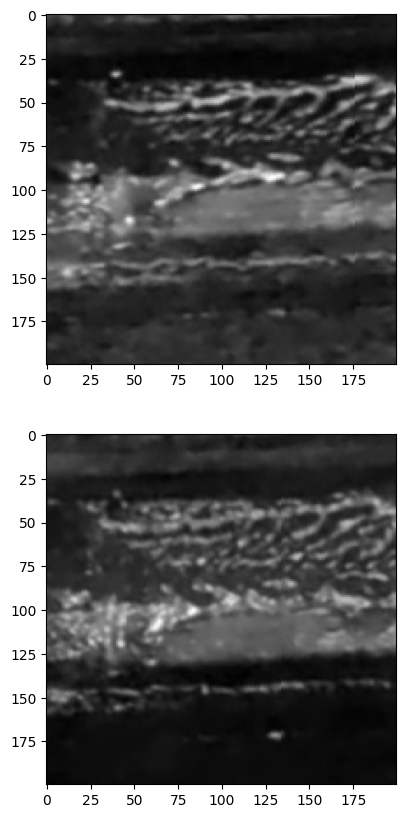

In [88]:
plt.figure(figsize=(20,10))
ax = plt.subplot(211)
ax.imshow(rows_images[0][start_row:start_row+rows_showed, start_column:start_column+columns_showed], cmap="gray")
ax = plt.subplot(212)
ax.imshow(rows_images[1][start_row-scan_shift:start_row-scan_shift+rows_showed, start_column+roll:start_column+columns_showed+roll], cmap="gray")
# ax = plt.subplot(211)
# ax.imshow(np.rot90(rows_images[0], 2)[1560:1560+rows_showed, 9500:9500+columns_showed], cmap="gray")
# ax = plt.subplot(212)
# ax.imshow(np.rot90(rows_images[1], 2)[1560-scan_shift:1560+rows_showed-scan_shift, 9500+roll:9500+columns_showed+roll], cmap="gray")
# ax = plt.subplot(211)
# ax.imshow(rows_images[0], cmap="gray")
# ax = plt.subplot(212)
# ax.imshow(rows_images[1], cmap="gray")
# ax = plt.subplot(211)
# ax.imshow(rows_images[1][1560:2160, :], cmap="gray")
# ax = plt.subplot(212)
# ax.imshow(rows_images[2][1560-shift:2160-shift, :], cmap="gray")
# ax = plt.subplot(211)
# ax.imshow(rows_images[0][:, 7500:10000], cmap="gray")
# ax = plt.subplot(212)
# ax.imshow(rows_images[1][:, 7500+roll:10000+roll], cmap="gray")
# ax = plt.subplot(513)
# ax.imshow(rows_images[2][:, 5000:7500], cmap="gray")
# ax = plt.subplot(514)
# ax.imshow(rows_images[3][:, 5000:7500], cmap="gray")
# ax = plt.subplot(515)
# ax.imshow(rows_images[4][:, 5000:7500], cmap="gray")

In [89]:
def mutual_information(imgA, imgB, bins=15):
    # taken from https://matthew-brett.github.io/teaching/mutual_information.html
    # print(imgA.shape, imgB.shape)
    hist_2d, x_edges, y_edges = np.histogram2d(
        imgA.ravel(),
        imgB.ravel(),
        bins=bins
    )
    pxy = hist_2d / float(np.sum(hist_2d))
    px = np.sum(pxy, axis=1)  # marginal for x over y
    py = np.sum(pxy, axis=0)  # marginal for y over x
    px_py = px[:, None] * py[None, :]  # Broadcast to multiply marginals

    # Now we can do the calculation using the pxy, px_py 2D arrays
    nzs = pxy > 0  # Only non-zero pxy values contribute to the sum
    return np.sum(pxy[nzs] * np.log(pxy[nzs] / px_py[nzs]))

def extract_images_and_compute_mi(shift, imgA, imgB, seed_position, width, height):
    # print(shift, height, width, seed_position)
    x = np.arange(seed_position[1, 0] + shift[0], seed_position[1, 0] + shift[0] + height - 0.5)
    y = np.arange(seed_position[1, 1] + shift[1], seed_position[1, 1] + shift[1] + width - 0.5)
    # print(x.shape, y.shape)
    xg, yg = np.meshgrid(x, y)
    # print(xg[0, 0], xg[-1,-1], yg[0,0], yg[-1,-1], imgA.shape, imgB.shape)
    # print(imgA[seed_position[0, 0]: seed_position[0, 0] + height,
    #     seed_position[0, 1]: seed_position[0, 1] + width].T.shape)
    interp = RegularGridInterpolator((np.arange(imgB.shape[0]), np.arange(imgB.shape[1])), imgB)
    return -mutual_information(
        imgA[seed_position[0, 0]: seed_position[0, 0] + height,
        seed_position[0, 1]: seed_position[0, 1] + width].T,
        interp((xg, yg))
    )

def to_minimize(x):
    return extract_images_and_compute_mi(shift=x, imgA=imgA, imgB=imgB,
                                              seed_position=seed_position,
                                              width=imgA.shape[1] - 2*abs(physics["roll"]) - 60,
                                              height=imgA.shape[0] - physics["scan_shift"] - 30)

def show_images(imgA, imgB, seed_position, shift):
    width = imgA.shape[1] - 2*abs(physics["roll"]) - 60
    height = imgA.shape[0] - physics["scan_shift"] - 30
    plt.figure(figsize=(8, 40))
    ax = plt.subplot(131)
    img1 = imgA[seed_position[0, 0]: seed_position[0, 0] + height,
              seed_position[0, 1]: seed_position[0, 1] + width].T
    print(img1.shape)
    ax.imshow(img1, cmap="gray")
    ax.set_title("Fixed")

    x = np.arange(seed_position[1, 0] + shift[0], seed_position[1, 0] + shift[0] + height - 0.5)
    y = np.arange(seed_position[1, 1] + shift[1], seed_position[1, 1] + shift[1] + width - 0.5)
    xg, yg = np.meshgrid(x, y)
    interp = RegularGridInterpolator((np.arange(imgB.shape[0]), np.arange(imgB.shape[1])), imgB)

    ax = plt.subplot(132)
    img2 = interp((xg, yg))
    print(img2.shape)
    ax.imshow(img2, cmap="gray")
    ax.set_title("Moved")

    ax = plt.subplot(133)
    img3 = img1 + img2
    print(img3.shape)
    ax.imshow(img3, cmap="gray")
    ax.set_title("Blend")
    plt.show()
               

In [90]:
video_file_path = os.path.join(SRC, video)
motions = VideoMotion(video_file_path)
motions.process()

NameError: name 'video' is not defined

In [38]:
physics = {
            "scan_shift": int(motions.get_average_vertical_shift()),
        }

if motions.is_moving_down():
    physics["roll"] = int(np.round(rows_images[0].shape[1] * 0.1)) + 36
else:
    physics["roll"] = -int(np.round(rows_images[0].shape[1] * 0.1)) + 36

physics["first_frame"] = (physics["scan_shift"] + 15, abs(physics["roll"]) + 30)

NameError: name 'motions' is not defined

In [99]:
int(np.round(rows_images[0].shape[1] * 0.0595)) + 36

479

In [91]:
physics = {"scan_shift": scan_shift, "roll": roll}

physics["first_frame"] = (physics["scan_shift"] + 15, abs(physics["roll"]) + 30)

In [92]:
scan_shifts = []
rolls = []

In [93]:
first_frame = physics["first_frame"]
scan_shift = physics["scan_shift"]
roll = physics["roll"]

scan_shifts.append(scan_shift)
rolls.append(roll)

seed_position = np.array([first_frame, [first_frame[0] - scan_shift, first_frame[1] + roll]]).astype(int)
imgA = rows_images[0]
imgB = rows_images[1]
# print(imgA.shape, imgB.shape)
s1 = minimize(to_minimize, x0=np.array([0, 0]), method='Powell', bounds=[(-15, +15),(-30, 30)], options={'xtol': 1e-2, 'ftol': 1e-2, 'disp': True})

Optimization terminated successfully.
         Current function value: -0.232459
         Iterations: 2
         Function evaluations: 78


In [94]:
s1

 message: Optimization terminated successfully.
 success: True
  status: 0
     fun: -0.23245914140127294
       x: [ 3.439e+00 -1.371e+01]
     nit: 2
   direc: [[ 0.000e+00  1.000e+00]
           [ 1.541e+00 -1.496e+00]]
    nfev: 78

(6404, 346)
(6404, 346)
(6404, 346)


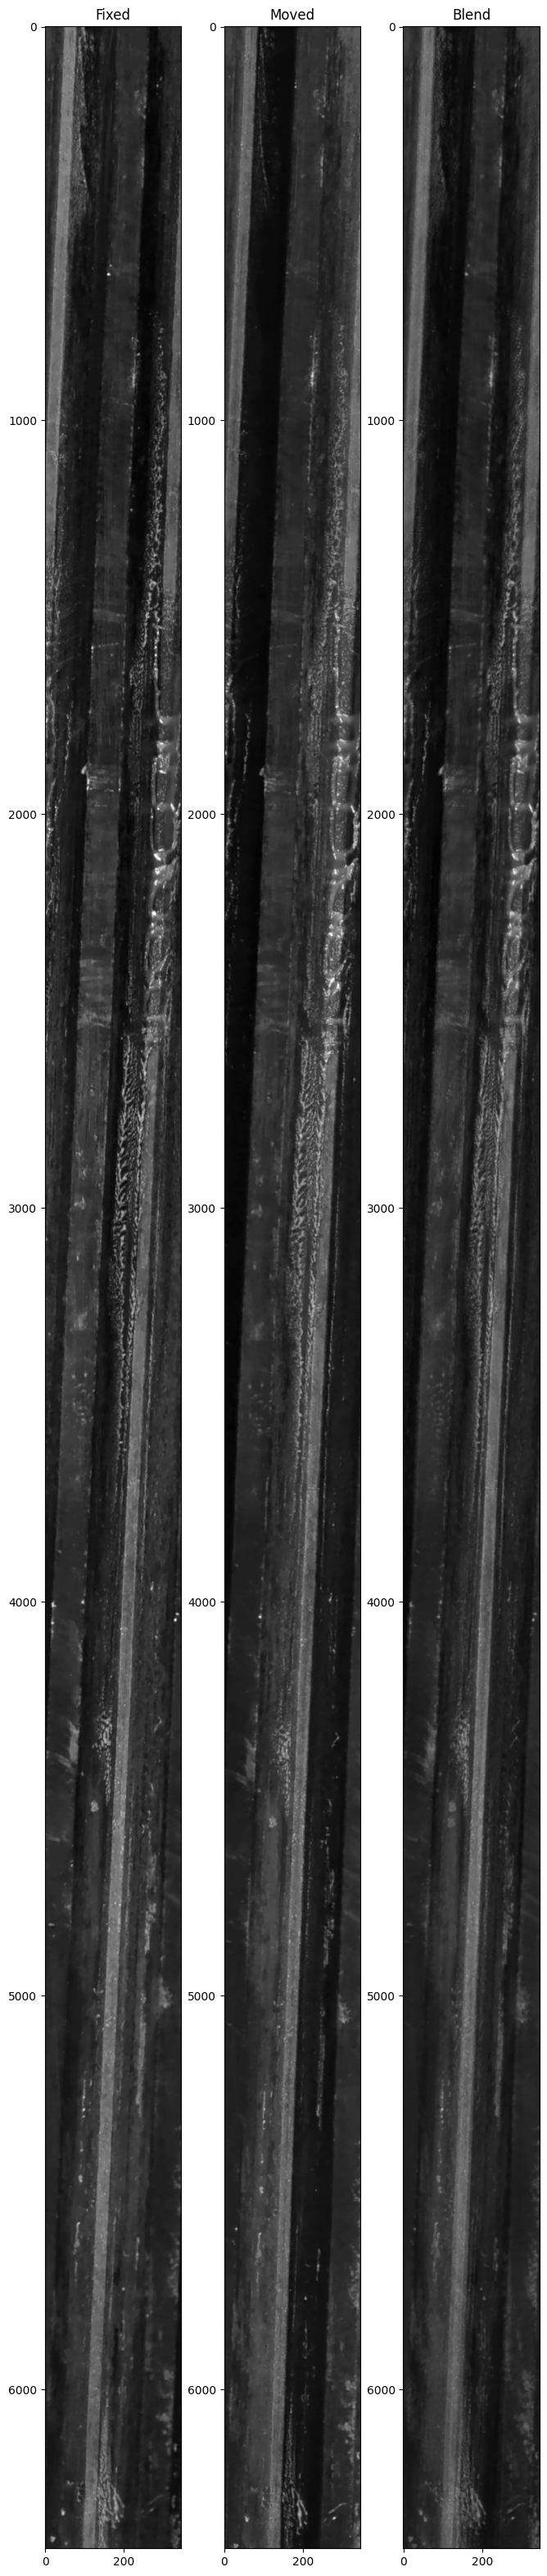

In [95]:
show_images(imgA, imgB, seed_position, s1.x)

In [ ]:
first_frame = physics["first_frame"]
scan_shift = physics["scan_shift"]

scan_shifts.append(scan_shift)
rolls.append(roll)
seed_position = np.array([first_frame, [first_frame[0] - scan_shift, first_frame[1] + roll]]).astype(int)
imgA = rows_images[1]
imgB = rows_images[2]
s2 = minimize(to_minimize, x0=np.array([0, 0]), method='Powell', bounds=[(-15, +15),(-30, 30)], options={'xtol': 1e-2, 'ftol': 1e-2, 'disp': True})

In [ ]:
s2

In [ ]:
show_images(imgA, imgB, seed_position, s2.x)

In [ ]:
scan_shifts.append(scan_shift)
rolls.append(roll)
seed_position = np.array([first_frame, [first_frame[0] - scan_shift, first_frame[1] + roll]]).astype(int)

imgA = rows_images[2]
imgB = rows_images[3]
s3 = minimize(to_minimize, x0=np.array([0, 0]), method='Powell', bounds=[(-15, +15),(-30, 30)], options={'xtol': 1e-2, 'ftol': 1e-2, 'disp': True})

In [ ]:
s3

In [ ]:
show_images(imgA, imgB, seed_position, s3.x)

In [ ]:
scan_shifts.append(scan_shift)
rolls.append(roll)
seed_position = np.array([first_frame, [first_frame[0] - scan_shift, first_frame[1] + roll]]).astype(int)
imgA = rows_images[3]
imgB = rows_images[4]
s4 = minimize(to_minimize, x0=np.array([0, 0]), method='Powell', bounds=[(-15, +15),(-30, 30)], options={'xtol': 1e-2, 'ftol': 1e-2, 'disp': True})

In [ ]:
s4

In [ ]:
show_images(imgA, imgB, seed_position, s4.x)

In [ ]:
scan_shifts.append(scan_shift)
rolls.append(roll)
seed_position = np.array([first_frame, [first_frame[0] - scan_shift, first_frame[1] + roll]]).astype(int)
imgA = rows_images[4]
imgB = rows_images[5]
s5 = minimize(to_minimize, x0=[0, 0], method='Powell', bounds=[(-10, 10),(-10, 40)])

In [ ]:
s5

In [ ]:
show_images(imgA, imgB, seed_position, s5.x)

In [ ]:
[[first_frame[0] - 5 * scan_shift + 13 * screw_thread_distance, first_frame[1] - 5 * roll],
 [first_frame[0] - 6 * scan_shift + 13 * screw_thread_distance, first_frame[1] - 6 * roll]]

In [ ]:
seed_position = np.array([[first_frame[0] - 5 * scan_shift + 13 * screw_thread_distance, first_frame[1] - 5 * roll],
                          [first_frame[0] - 6 * scan_shift + 13 * screw_thread_distance, first_frame[1] - 6 * roll]]).astype(int)
imgA = rows_images[5]
imgB = rows_images[6]
s6 = minimize(to_minimize, x0=[0, 0], method='Powell', bounds=[(-10, 10),(-10, 40)])

In [ ]:
s6

In [ ]:
show_images(imgA, imgB, seed_position, s6.x)

In [ ]:
shift_fixes = np.array([s1.x, s2.x, s3.x])

## Merge

- sesbírat posun per row
- aggregovats `sn.x`
- provést roll každé otočky + interpolaci
- vyrobit váhovou matici pro překryv
- vynásobit / flatnout

In [ ]:
shift_seed = []
shift_seed.append(np.array([first_frame, [first_frame[0] - scan_shifts[0], first_frame[1] + rolls[0]]]).astype(int))
shift_seed.append(np.array([first_frame, [first_frame[0] - scan_shifts[1], first_frame[1] + rolls[1]]]).astype(int))
shift_seed.append(np.array([first_frame, [first_frame[0] - scan_shifts[2], first_frame[1] + rolls[2]]]).astype(int))

In [ ]:
per_row_shift = np.array([seed[0, :] - seed[1, :] - fix for seed, fix in zip(shift_seed, shift_fixes)])

In [ ]:
shift_seed

In [ ]:
per_row_shift

In [ ]:
def real_roll(array, shift, axis=0):    
    double_image = np.concatenate([array, array], axis=1)
    interp = RegularGridInterpolator(
        (np.arange(double_image.shape[0]), np.arange(double_image.shape[1])), 
        double_image
    )
    if shift > 0:
        y = np.arange(shift, shift + array.shape[1] - 0.5, 1)
    else:
        y = np.arange(shift + array.shape[1], 2 * array.shape[1] + shift - 0.5, 1)    
    x = np.arange(array.shape[0])    
    xg, yg = np.meshgrid(x, y)    
    return interp((xg, yg)).T

In [ ]:
rows_images[1][:,:12]

In [ ]:
# Test of the real roll function
plt.figure(figsize=(20,6))
ax = plt.subplot(211)
ax.imshow(real_roll(rows_images[1], per_row_shift[0,1]), cmap="gray")
ax.set_title("Rolled")
ax = plt.subplot(212)
ax.imshow(rows_images[1], cmap="gray")
ax.set_title("Original row 1")
plt.show()

In [ ]:
rows_images[0].shape

In [ ]:
rolled = []
# Roll all rows as required and plot them
plt.figure(figsize=(20,20))
ax = plt.subplot(7, 1, 1)
ax.imshow(rows_images[0], cmap="gray")
rolled.append(rows_images[0])
for en, row_shift in enumerate(np.cumsum(-per_row_shift[:,1])):
    ax = plt.subplot(7, 1, en+2)
    rolled.append(real_roll(rows_images[en + 1], row_shift % rows_images[en + 1].shape[1]))
    ax.imshow(rolled[-1], cmap="gray")
    ax.set_title(f"Row {en + 1}, shift: {row_shift % rows_images[en + 1].shape[1]}")
plt.show()

In [ ]:
# merge rows

In [ ]:
to_grid = [rolled[0]]
real_shift = [0]
for image, shift in tqdm(zip(rolled[1:], np.cumsum(per_row_shift[:,0])), total=per_row_shift.shape[0]):
    interp = RegularGridInterpolator(
        (np.arange(image.shape[0]), np.arange(image.shape[1])), 
        image
    )
    x = np.arange(image.shape[0] - 1)
    y = np.arange(image.shape[1])
    xg, yg = np.meshgrid(x,y)
    to_grid.append(interp((xg, yg)).T)
    real_shift.append(int(shift // 1))


In [ ]:
out_height = rolled[0].shape[0] + np.max(real_shift)

In [ ]:
full_image = np.zeros((out_height, rolled[0].shape[1], len(rolled)))
for en, (image, r_shift) in enumerate(zip(to_grid, real_shift)):
    full_image[r_shift: r_shift + image.shape[0], :, en] = image

In [ ]:
blend_matrix = np.zeros((out_height, to_grid[0].shape[1], len(to_grid)))

blend_matrix[:real_shift[1], :, 0] += 1
lin_blend = np.dot(np.arange(0, 1, 1/(to_grid[0].shape[0] - real_shift[1])).reshape(-1, 1), 
                   np.ones((to_grid[0].shape[1],1)).T)
blend_matrix[real_shift[1]: to_grid[0].shape[0], :, 0] += np.flipud(lin_blend)
blend_matrix[real_shift[1]: to_grid[0].shape[0], :, 1] += lin_blend

for en, (image, r_shift) in enumerate(list(zip(to_grid, real_shift))[:-2]):
    blend_matrix[real_shift[en] + to_grid[en].shape[0]: real_shift[en + 2], :, en + 1] += 1
    lin_blend = np.dot(np.arange(0, 1, 1/(to_grid[en + 1].shape[0] + real_shift[en + 1] - real_shift[en + 2])).reshape(-1, 1), 
                       np.ones((to_grid[en + 1].shape[1],1)).T)
    blend_matrix[real_shift[en + 2]: to_grid[en + 1].shape[0] + real_shift[en + 1], :, en + 1] += np.flipud(lin_blend)
    blend_matrix[real_shift[en + 2]: to_grid[en + 1].shape[0] + real_shift[en + 1], :, en + 2] += lin_blend

blend_matrix[to_grid[en + 1].shape[0] + real_shift[en + 1]:, :, -1] += 1

In [ ]:
blended_full_image = np.sum(full_image * blend_matrix, axis=2) / np.sum(blend_matrix, axis=2)

## Conclusion - Image READY

In [ ]:
iio.imwrite(os.path.join(SRC, videos[-2]).replace(".MP4", "-oio-100.png"), blended_full_image.astype(np.uint8))

# Rotate to diff

In [ ]:
edges = cv2.Canny(blended_full_image.astype(np.uint8),80,200)

In [ ]:
plt.figure(figsize=(15,8))
plt.imshow(edges, cmap="gray")
plt.show()

In [ ]:
lines = cv2.HoughLines(edges, 10, np.pi/1800, 1, min_theta=4/5 * np.pi, max_theta=np.pi)


In [ ]:
plt.plot(lines[:,0,1])
plt.show()

### Odbočka - copak je v GPMF datech

In [ ]:
import gpmf
from scipy.ndimage import gaussian_filter1d as gaussian
from scipy.signal import butter, sosfilt

In [ ]:
gpmf_stream = gpmf.io.extract_gpmf_stream(os.path.join(SRC, videos[0]))

In [ ]:
stream_content = []
for s in gpmf.parse.filter_klv(gpmf_stream, "GYRO"):
    content = []
    is_gyro = False
    for elt in s.value:
        content.append(elt)
        
    stream_content.append(content)

In [ ]:
len(stream_content) * 207

In [ ]:
len(stream_content[0])

In [ ]:
plt.figure(figsize=(15,5))
ax=plt.subplot(111)
x = gaussian([np.mean([x for x, _, _ in content]) for content in stream_content], 1)
ax.plot(x - np.mean(x), label="horizontal")
y = gaussian([np.mean([x for _, x, _ in content]) for content in stream_content], 1)
ax.plot(y - np.mean(y), label="lens axis")
z = gaussian([np.mean([x for _, _, x in content]) for content in stream_content], 1)
ax.plot(z - np.mean(z), label="vertical")
plt.ylabel("rad/s")
plt.xlabel("video time (x)")
plt.legend()
plt.show()

In [ ]:
from pykalman import KalmanFilter

In [ ]:
kf = KalmanFilter(n_dim_obs=1, em_vars=['transition_covariance', 'observation_covariance', 'initial_state_mean'])

In [ ]:
plt.plot(np.arange(0, len(y), 10), kf.em(y, n_iter=10).smooth(y[::10])[0].reshape(-1))
plt.plot(buttap(y))
plt.show()

In [ ]:
sos = butter(1, 60, 'hp', fs=1000, output='sos')
filtered = sosfilt(sos, y)

In [ ]:
plt.plot(filtered)
plt.plot(y)
plt.show()